In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
dataset = pd.read_csv('desafio_indicium_imdb.csv', index_col=0)
print(dataset.head(1))
print(dataset.info())
missing_counts = dataset.isna().sum()[dataset.isna().sum() > 0]
missing_percent = (missing_counts / len(dataset)) * 100
print(pd.DataFrame({'Missing Count': missing_counts, 'Missing %': missing_percent}))
print(dataset.isna().sum()[dataset.isna().sum() > 0])


    Series_Title Released_Year Certificate  Runtime         Genre  \
1  The Godfather          1972           A  175 min  Crime, Drama   

   IMDB_Rating                                           Overview  Meta_score  \
1          9.2  An organized crime dynasty's aging patriarch t...       100.0   

               Director          Star1      Star2       Star3         Star4  \
1  Francis Ford Coppola  Marlon Brando  Al Pacino  James Caan  Diane Keaton   

   No_of_Votes        Gross  
1      1620367  134,966,411  
<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non

#### Nessa etapa do EDA ainda estou lidando com os tipos de coluna e preprocessamento dos dados.

- Para o Certificate, transformei a coluna para o tipo de category, e os NaN transformei em "Unrated"
- Em certificate após tentar a etapa de treino de algoritmos percebi que tinham 2 categorias (GP e U/A) que tinham poucos registros, as tratei e substitui por PG e UA respectivamente, que era o grupo maior.
- Com Runtime eu separei a coluna em duas: Runtime_time para o valor númerico do tempo e Runtime_type para o tipo de tempo (min ou hour se houvesse.)
- **Para o Genre, identifiquei que cada valor é uma lista de gêneros separados por ", " portanto manterei a coluna dessa forma e usarei isso na Pipeline do scikit learn para ter um encodding válido.**
- Para a feature Director simplesmente transformei para o tipo categórico.
- Para as features de Star, as transformei para categórico também.
- Enquanto Gross subtitui as "," por vazio e pude transformar em uma coluna numérica.
- Para o Released_Year, exclui o registro com essa feature com 'PG', pois um registro não representará problemas para o modelo.
- Para preencher os valores faltantes da coluna Gross, escolhi uma abordagem de preencher primeiramente pela mediana agrupada pelos diretores do filme, após isso pela mediana do gênero e depois pela mediana geral.

In [18]:
dataset['Certificate'] = dataset['Certificate'].astype('category')
dataset['Certificate'] = dataset['Certificate'].fillna('Unrated')
dataset['Certificate'] = dataset['Certificate'].replace({
    'U/A': 'UA',
    'GP': 'PG'
})

dataset['Runtime_time'] = dataset['Runtime'].str.split().str[0].astype(int)
dataset['Runtime_type'] = dataset['Runtime'].str.split().str[1].astype('category')

dataset['Director'] = dataset['Director'].astype('category')

dataset['Star1'] = dataset['Star1'].astype('category')
dataset['Star2'] = dataset['Star2'].astype('category')
dataset['Star3'] = dataset['Star3'].astype('category')
dataset['Star4'] = dataset['Star4'].astype('category')

dataset['Gross'] = dataset['Gross'].astype(str).str.replace(',', '')
dataset['Gross'] = pd.to_numeric(dataset['Gross'], errors='coerce')


dataset = dataset[dataset['Released_Year'] != 'PG']
dataset['Released_Year'] = dataset['Released_Year'].astype('int')

dataset['Gross'] = dataset['Gross'].fillna(dataset.groupby('Director')['Gross'].transform('median'))
dataset['Gross'] = dataset['Gross'].fillna(dataset.groupby('Genre')['Gross'].transform('median'))
dataset['Gross'] = dataset['Gross'].fillna(dataset['Gross'].median())

print(dataset.info())
print(dataset.isna().sum()[dataset.isna().sum() > 0])

<class 'pandas.core.frame.DataFrame'>
Index: 998 entries, 1 to 999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Series_Title   998 non-null    object  
 1   Released_Year  998 non-null    int64   
 2   Certificate    998 non-null    category
 3   Runtime        998 non-null    object  
 4   Genre          998 non-null    object  
 5   IMDB_Rating    998 non-null    float64 
 6   Overview       998 non-null    object  
 7   Meta_score     841 non-null    float64 
 8   Director       998 non-null    category
 9   Star1          998 non-null    category
 10  Star2          998 non-null    category
 11  Star3          998 non-null    category
 12  Star4          998 non-null    category
 13  No_of_Votes    998 non-null    int64   
 14  Gross          998 non-null    float64 
 15  Runtime_time   998 non-null    int64   
 16  Runtime_type   998 non-null    category
dtypes: category(7), float64(3), int64(3), ob

C:\Users\Pedro Cunha\AppData\Local\Temp\ipykernel_19896\4011608897.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset['Certificate'] = dataset['Certificate'].replace({
C:\Users\Pedro Cunha\AppData\Local\Temp\ipykernel_19896\4011608897.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset['Gross'] = dataset['Gross'].fillna(dataset.groupby('Director')['Gross'].transform('median'))


#### Interpretação do Pairplot e correlação entre as variáveis numéricas

- Existe uma concentração de muitos filmes entre 50 e aproximadamente 90, porém os que passam de 90 parecem ter maior IMDB_Rating.
- A maioria dos filmes tem até 2 milhões de votos, porém é concentrado até 500 mil votos, e os que fogem dessa concentração são os que tendem a ter maior IMDB_Rating.
- Em relação ao Runtime_time, filmes com maior duração tendem a ter notas mais altas no IMDB, fica mais notável a partir de 200 min.
- Olhando apenas a relação No_of_votes e Gross, filmes mais populares (com mais votos) geralmente arrecadam mais.

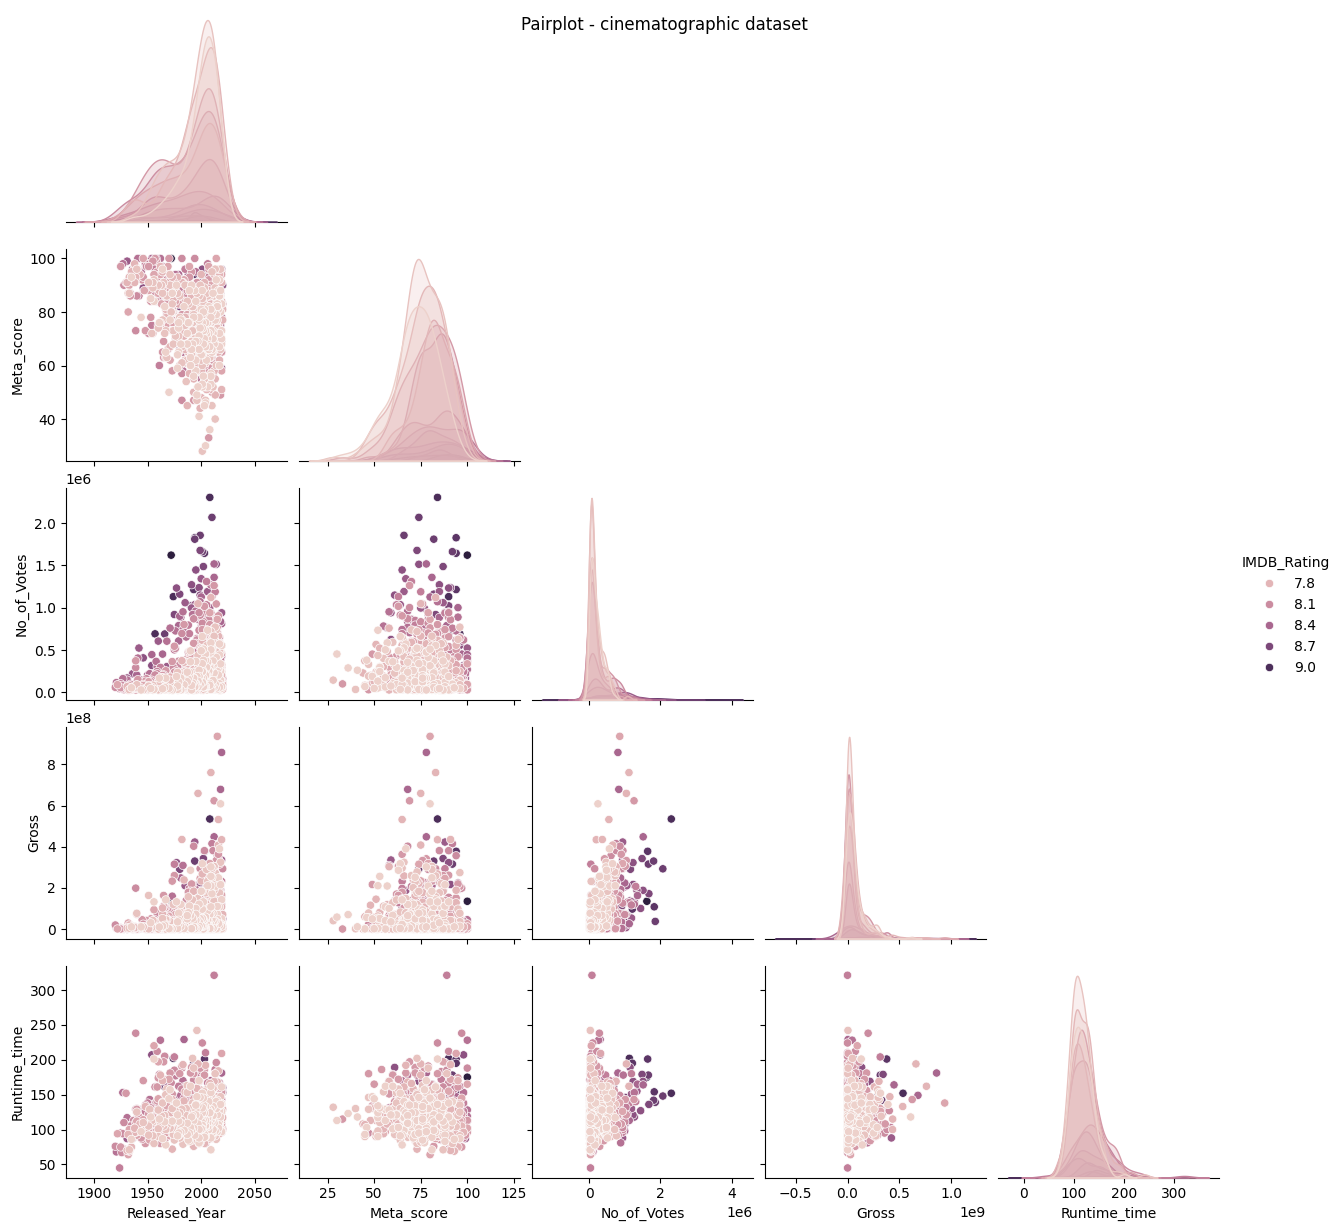

In [19]:
sns.pairplot(dataset, hue='IMDB_Rating', corner=True)
plt.suptitle('Pairplot - cinematographic dataset')
plt.show()

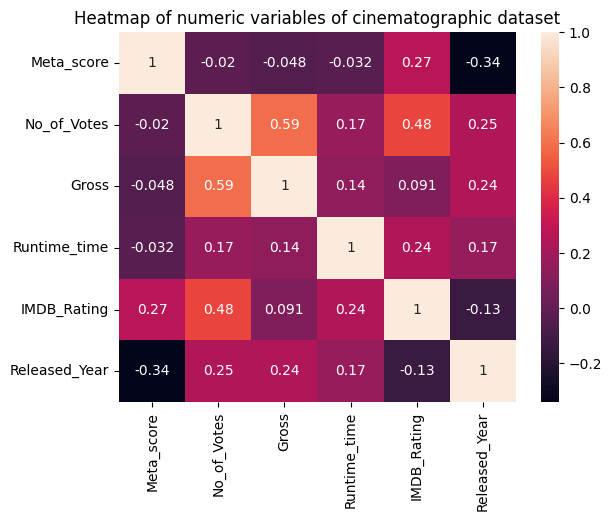

In [20]:
heatmap = dataset[['Meta_score', 'No_of_Votes', 'Gross', 'Runtime_time', 'IMDB_Rating', 'Released_Year']].corr()

sns.heatmap(heatmap, annot=True)
plt.title('Heatmap of numeric variables of cinematographic dataset')
plt.show()

#### Interpretação dos violin plots dos genêros dos filmes.

- Os ratings são muito semelhantes para a maioria dos gêneros, entre 7.5 e 8.3.
- Poucos gêneros, como o de War, Mystery e Film-Noir parecem ter medianas um pouco mais altas, um pouco maior que 8.0
- Horror e Family parecem ter as medianas mais baixas, algo proximo de 7.7
- Em relação a distribuição é visto que a maioria são bastante parecidas, apenas Film-Noir que é mais agrupada próximo a mediana.

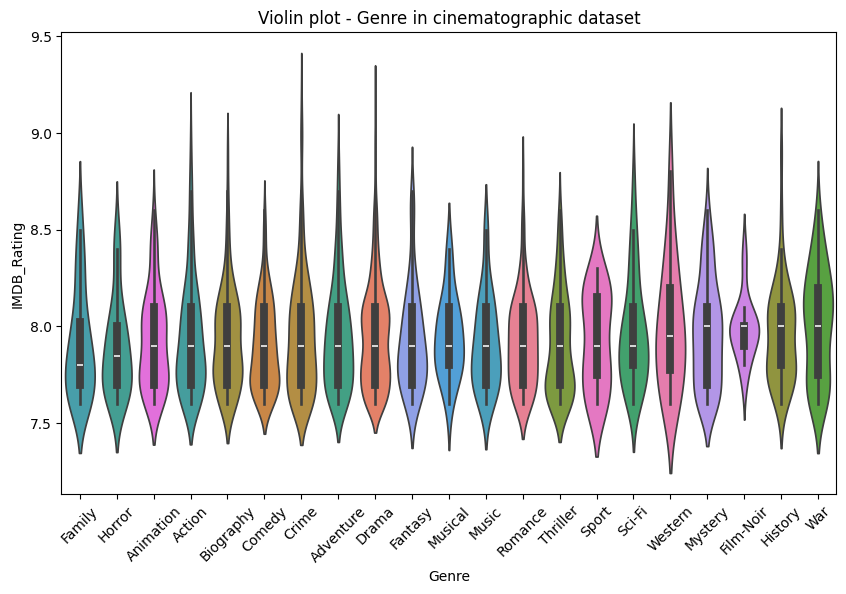

In [21]:

df_exploded = dataset.assign(Genre=dataset["Genre"].str.split(", ")).explode("Genre")
df_exploded = df_exploded.sort_values(by='Series_Title')

medians = df_exploded.groupby("Genre")["IMDB_Rating"].median().sort_values()


plt.figure(figsize=(10,6))
sns.violinplot(data=df_exploded, x="Genre", y="IMDB_Rating", hue='Genre', order=medians.index)
plt.title('Violin plot - Genre in cinematographic dataset')
plt.xticks(rotation=45)
plt.show()

#### Visualização da evolução do IMDB_Rating ao passar das décadas.

Olhando para a linha no gráfico vemos que há uma variação durante os anos mas tende a permanece a mesma média de IMDB_Rating.

Porém ao observarmos o intervalo de confiança gerado vemos que existe uma maior variação dentre os anos, principalmente entre 1975 e 1980.

- O desvio padrão em todo o intervalo é de 0.272

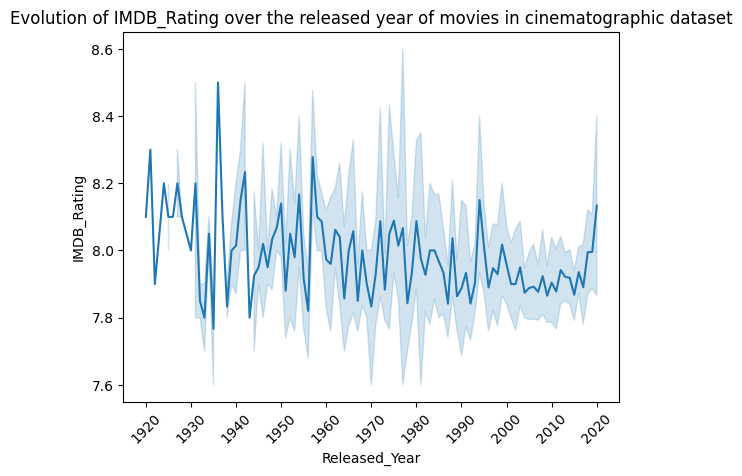

Desvio padrão do IMDB_Rating: 0.2722028423263218


In [22]:
sns.lineplot(
    data=dataset, x='Released_Year', y='IMDB_Rating',
    errorbar=('ci')
)
plt.xticks(np.arange(dataset['Released_Year'].min(), dataset['Released_Year'].max()+1, 10), rotation=45)
plt.title('Evolution of IMDB_Rating over the released year of movies in cinematographic dataset')
plt.show()

print(f"Desvio padrão do IMDB_Rating: {dataset['IMDB_Rating'].std()}")


#### Aplicando teste ANOVA

Estou fazendo um teste ANOVA com 0.05 de nível de significância, para analisar as diferenças entre as médias de IMDB_Rating entre atores, gêneros e diretores.

**Gênero**  
- H0: Não há diferença entre entre as médias de IMDB_Rating entre os grupos de gênero.
- H1: Há uma diferença entre as médias.

Obtive um resultado com p-value de 0.45, muito maior que o nível de significância, levando a não rejeitar a hipótese nula, significando que provavelmente não há diferenças.

**Atores**
- H0: Não há diferença entre as médias de IMDB_Rating entre os atores.
- H1: Há uma diferença entre as médias

Obtive um resultado com p-value de 0.94, levando a não rejeitar a hipótese nula.

**Diretores**
- H0: Não há diferença entre as médias de IMDB_Rating entre os diretores.
- H1: Há uma diferença entre as médias

Obtive um resultado com p-value de 0.08, levando a não rejeitar a hipótese nula.

> *Como existem mais de 2000 atores diferentes e mais de 500 diretores (alta cardinalidade), não pude criar uma visualização da distribuição de IMDB_Rating por ator ou por diretor.*
> Portanto irei utiliar como estratégia de sampling pegar até 14 atores/diretores entre o dataset para visualizar essa distribuiçào, e refazer o teste ANOVA para ver se continua batendo.


In [23]:
groups = [group['IMDB_Rating'].values for name, group in df_exploded.groupby('Genre')]

f_stat, p_val = f_oneway(*groups)
print(f'f-statistic: {f_stat}')
print(f'p-value: {p_val}')

if p_val < 0.05:
    print('Rejeitamos a hipótese nula.')
    print('O teste ANOVA dá indícios de que as médias de IMDB_Rating são diferentes entre os gêneros.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os gêneros.')
    

f-statistic: 1.0220461882379246
p-value: 0.43127166937040673
Não rejeitamos a hipótese nula.
O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os gêneros.


In [24]:
dataset_stars = dataset.melt(
    id_vars=['Series_Title', 'IMDB_Rating'],
    value_vars=['Star1', 'Star2', 'Star3', 'Star4'],
    var_name='Star_Pos',
    value_name='Actor'
)
groups = [group['IMDB_Rating'].values for name, group in dataset_stars.groupby('Actor')]

f_stat, p_val = f_oneway(*groups)

print(f'f-statistic: {f_stat}')
print(f'p-value: {p_val}')

if p_val < 0.05:
    print('Rejeitamos a hipótese nula.')
    print('O teste ANOVA dá indícios de que as médias de IMDB_Rating são diferentes entre os atores.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os atores.')


f-statistic: 0.9362567639637842
p-value: 0.9170528878111079
Não rejeitamos a hipótese nula.
O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os atores.


In [25]:
groups = [group['IMDB_Rating'].values for name, group in dataset.groupby('Director', observed=True)]

f_stat, p_val = f_oneway(*groups)
print(f'f-statistic: {f_stat}')
print(f'p-value: {p_val}')

if p_val < 0.05:
    print('Rejeitamos a hipótese nula.')
    print('O teste ANOVA dá indícios de que as médias de IMDB_Rating são diferentes entre os diretores.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os diretores.')

f-statistic: 1.135289149349676
p-value: 0.08033702636419716
Não rejeitamos a hipótese nula.
O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os diretores.


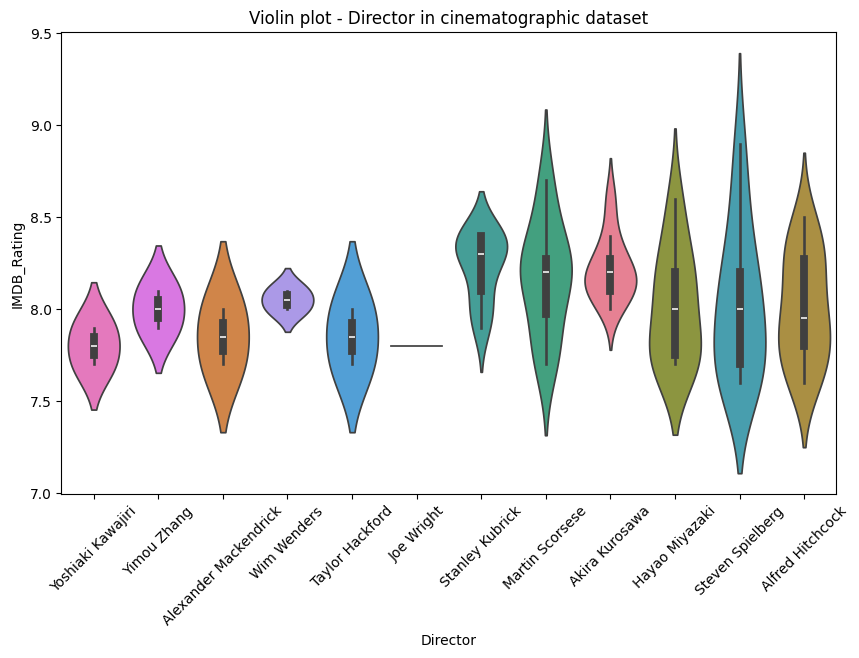

f-statistic: 1.2530974329875098
p-value: 0.27101413591458434
Não rejeitamos a hipótese nula.
O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os diretores.


In [35]:
directors_productions = dataset.groupby('Director', observed=False).size().sort_values(ascending=False)
above_mean_directors = directors_productions[directors_productions >= directors_productions.mean()]
top_6_directors = above_mean_directors.head(6)
tail_6_directors = above_mean_directors.tail(6)
dataset_directors = pd.concat([
    top_6_directors,  tail_6_directors
])

directors_productions = dataset[dataset['Director'].isin(dataset_directors.index)].copy()
directors_productions['Director'] = directors_productions['Director'].cat.remove_unused_categories()

ordered = dataset_directors.sort_values(ascending=True)

plt.figure(figsize=(10,6))
sns.violinplot(data=directors_productions, x="Director", y="IMDB_Rating", hue='Director', order=ordered.index)
plt.xticks(rotation=45)
plt.title('Violin plot - Director in cinematographic dataset')
plt.show()

groups = [group['IMDB_Rating'].values for name, group in directors_productions.groupby('Director', observed=True)]

f_stat, p_val = f_oneway(*groups)
print(f'f-statistic: {f_stat}')
print(f'p-value: {p_val}')

if p_val < 0.05:
    print('Rejeitamos a hipótese nula.')
    print('O teste ANOVA dá indícios de que as médias de IMDB_Rating são diferentes entre os diretores.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os diretores.')
    

Actor
Yami Gautam           2
Yul Brynner           2
Zachary Quinto        2
Yukito Nishii         2
Yvonne Furneaux       2
Zach Galifianakis     2
Christian Bale       11
Clint Eastwood       12
Brad Pitt            12
Tom Hanks            13
Al Pacino            13
Robert De Niro       17
dtype: int64


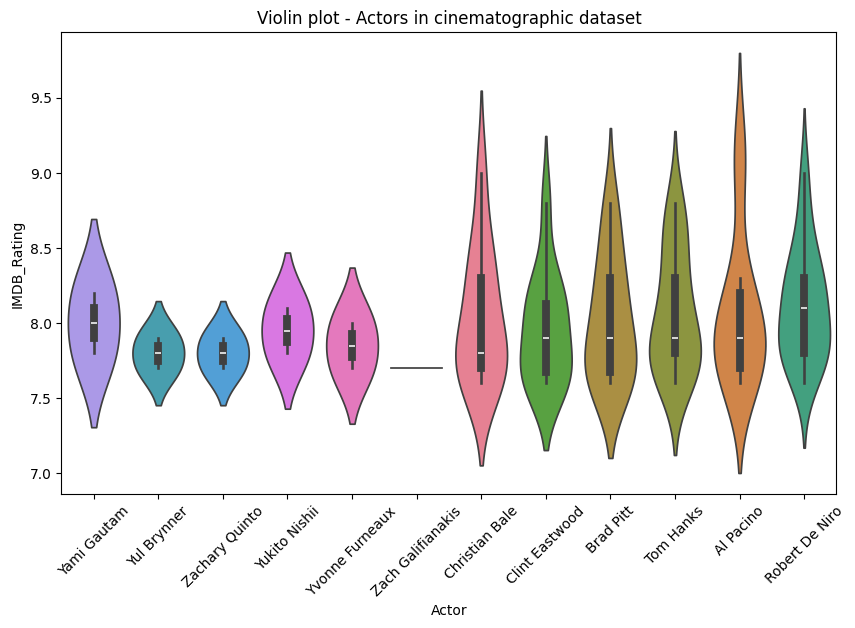

f-statistic: 0.42227123279084394
p-value: 0.9418985673745076
Não rejeitamos a hipótese nula.
O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os atores.


In [34]:
actors_production = dataset_stars.groupby('Actor').size().sort_values(ascending=False)

above_mean_actors = actors_production[actors_production >= actors_production.mean()]

top_6_actors = above_mean_actors.head(6)
tail_6_actors = above_mean_actors.tail(6)

dataset_actors = pd.concat([top_6_actors, tail_6_actors])
actors_production = dataset_stars[dataset_stars['Actor'].isin(dataset_actors.index)].copy()

ordered = dataset_actors.sort_values(ascending=True)
print(ordered)
plt.figure(figsize=(10,6))
sns.violinplot(data=actors_production, x="Actor", y="IMDB_Rating", hue='Actor', order=ordered.index)
plt.xticks(rotation=45)
plt.title('Violin plot - Actors in cinematographic dataset')
plt.show()

groups = [group['IMDB_Rating'].values for name, group in actors_production.groupby('Actor', observed=True)]

f_stat, p_val = f_oneway(*groups)
print(f'f-statistic: {f_stat}')
print(f'p-value: {p_val}')

if p_val < 0.05:
    print('Rejeitamos a hipótese nula.')
    print('O teste ANOVA dá indícios de que as médias de IMDB_Rating são diferentes entre os atores.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('O teste ANOVA não dá indícios de que as médias de IMDB_Rating sejam diferentes entre os atores.')


#### Criação de novas features

- Criando intervalos de anos de lançamento.
- Criando nova feature categórica baseado na duração do filme, short, medium e long.
- Contando a quantidade de gêneros por filme 
- Contando a quantidade de palavras chaves que aparecem no Overview, utilizando CountVectorizer para Overview.
- Medindo a "popularidade" do diretor com base na quantidade de filmes que já produziu.
- Contando a quantidade de palavras no total que o Overview possui.

In [36]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stopwords_en = stopwords.words('english')

vec = CountVectorizer(stop_words=stopwords_en, lowercase=True)

X = vec.fit_transform(dataset['Overview'])
words_count = np.array(X.sum(axis=0))[0]

counts_df = pd.DataFrame({
    'word': vec.get_feature_names_out(),
    'count': words_count
})
counts_df.sort_values('count', ascending=False).head(300).to_csv('keywords.csv', index=False)
keywords = counts_df.sort_values('count', ascending=False).head(300)['word'].tolist()

dataset['No_keywords'] = dataset['Overview'].apply(lambda text: sum(word in text.lower() for word in keywords))
print(dataset[['Overview', 'No_keywords']].head(2))



[nltk_data] Downloading package stopwords to C:\Users\Pedro
[nltk_data]     Cunha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                            Overview  No_keywords
1  An organized crime dynasty's aging patriarch t...            6
2  When the menace known as the Joker wreaks havo...            8


In [29]:

dataset['Released_Year_Group'] = (dataset['Released_Year'] // 10) * 10
print(dataset[['Released_Year', 'Released_Year_Group']].head(2))

dataset['Runtime_category'] = np.where(
    dataset['Runtime_time'] < 90,
    'short',
    np.where(dataset['Runtime_time'] < 120, 'medium', 'long')
)
print(dataset[['Runtime_category', 'Runtime_time']].head(2))

dataset['No_Genres'] = dataset['Genre'].str.split(', ').str.len()
print(dataset[['No_Genres', 'Genre']].head(2))

dataset['Director_No_Movies'] = dataset.groupby('Director', observed=False)['Director'].transform('count')
print(dataset[['Director', 'Director_No_Movies']].head(2))

dataset['Overview_length'] = dataset['Overview'].str.split(' ').str.len()
print(dataset[['Overview_length', 'Overview']].head(2))
print(f'STD de Overview_length: {dataset["Overview_length"].std()}')
print(dataset['Overview_length'].max())
print(dataset['Overview_length'].min())
print(dataset['Overview_length'].mean())

   Released_Year  Released_Year_Group
1           1972                 1970
2           2008                 2000
  Runtime_category  Runtime_time
1             long           175
2             long           152
   No_Genres                 Genre
1          2          Crime, Drama
2          3  Action, Crime, Drama
               Director  Director_No_Movies
1  Francis Ford Coppola                   5
2     Christopher Nolan                   8
   Overview_length                                           Overview
1               16  An organized crime dynasty's aging patriarch t...
2               33  When the menace known as the Joker wreaks havo...
STD de Overview_length: 7.790104784169879
56
8
25.018036072144287


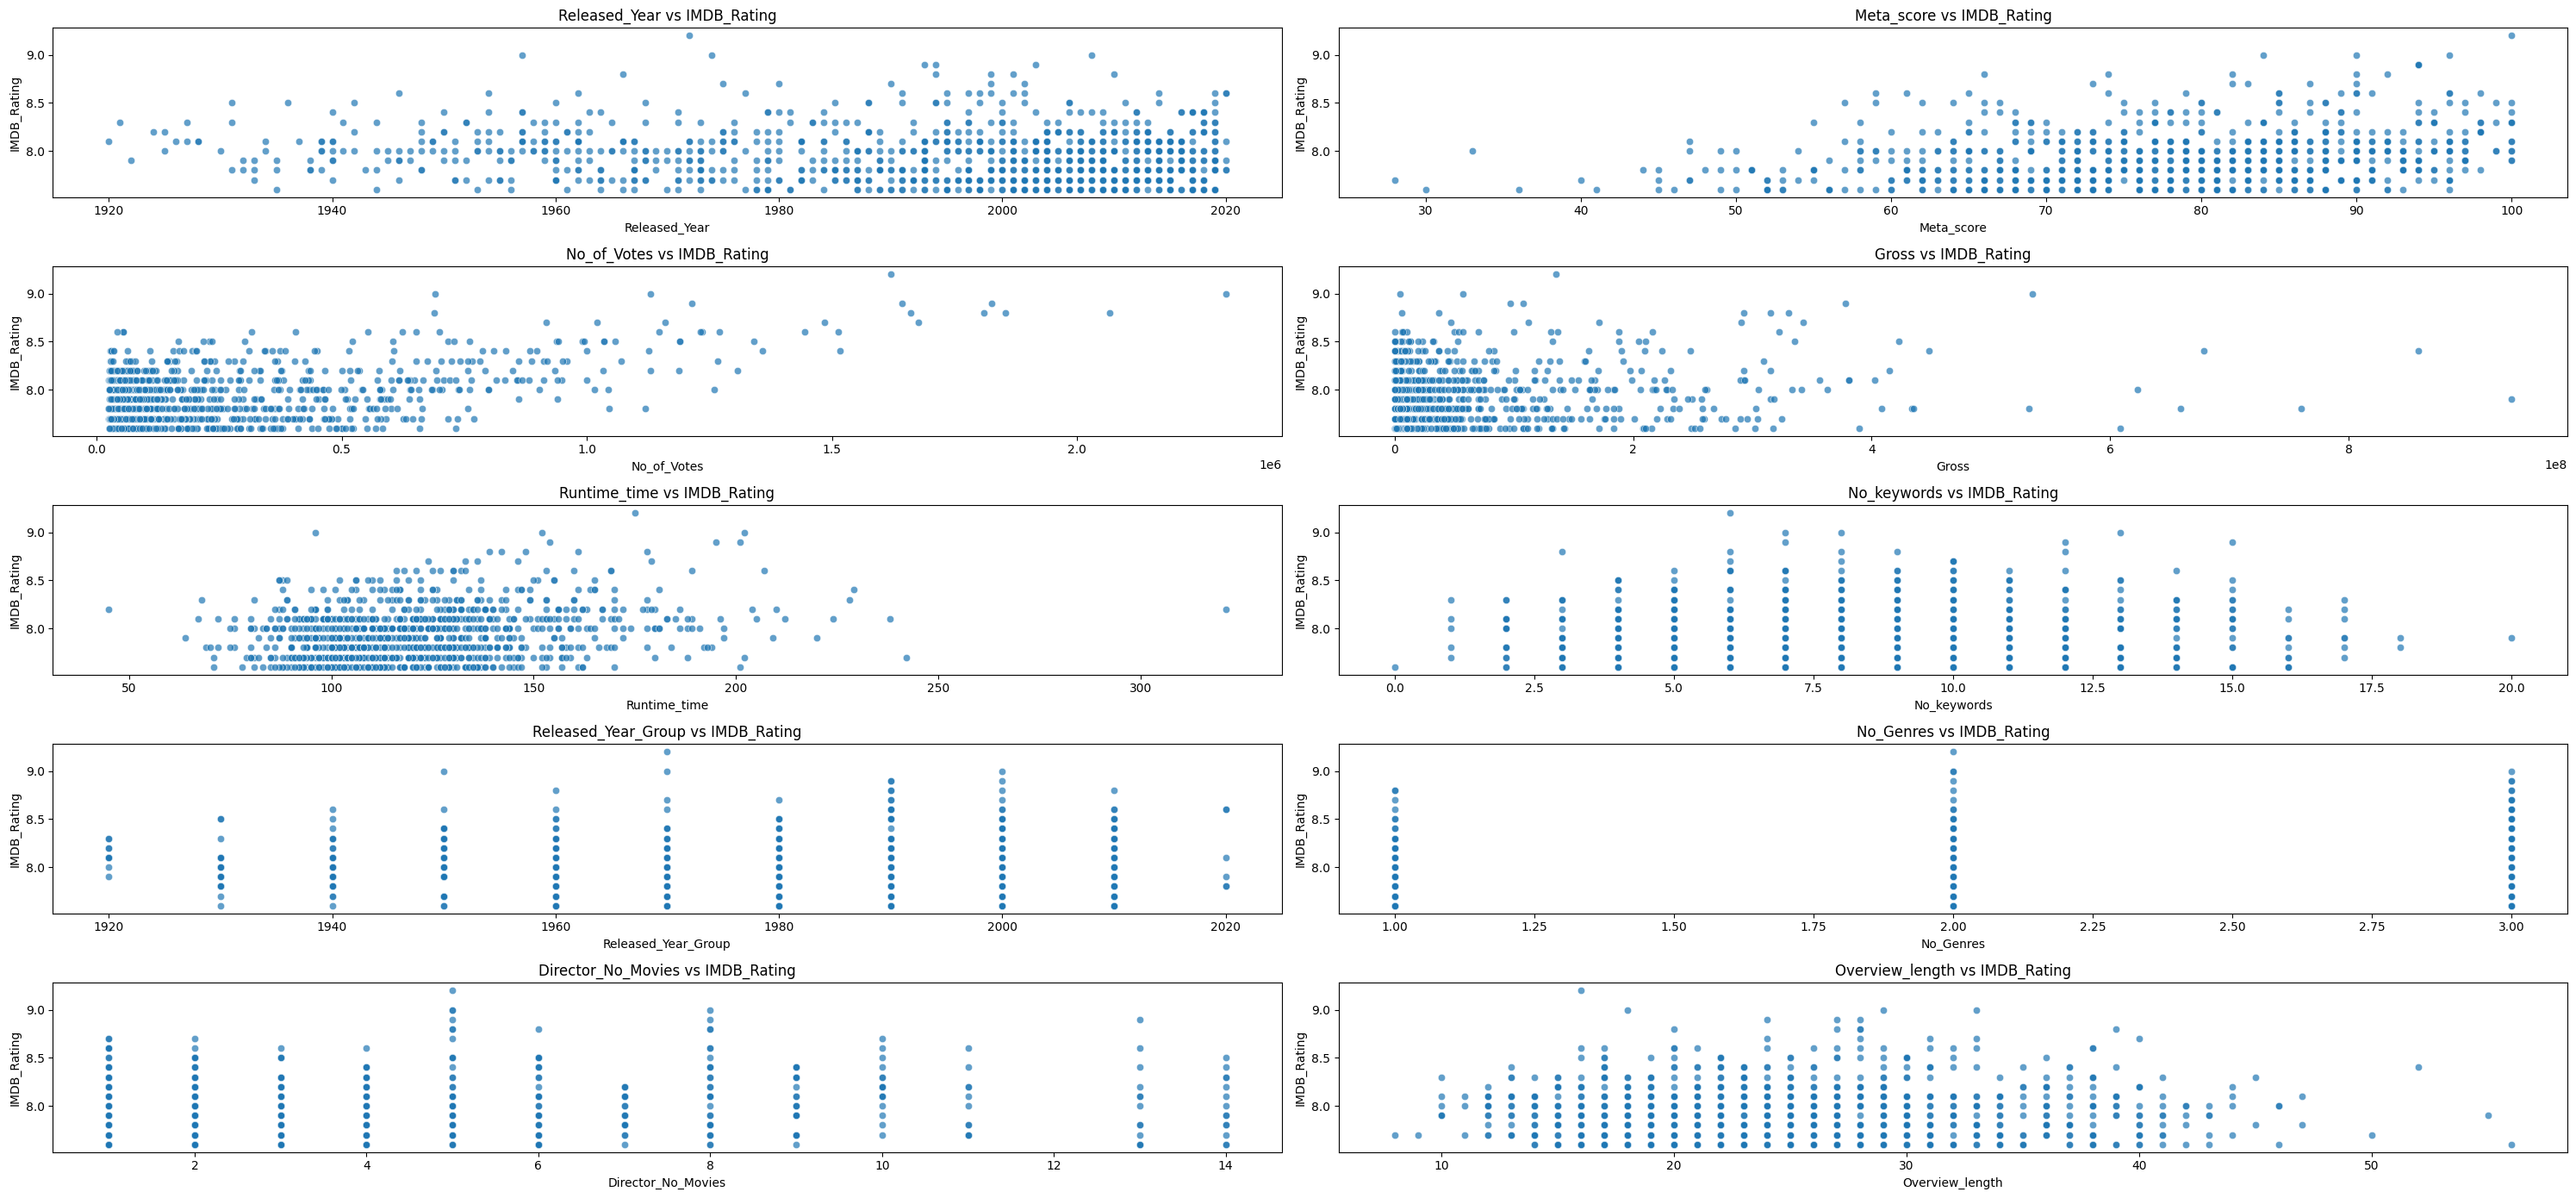

[9.2 9.  8.9 8.8 8.7 8.6 8.5 8.4 8.3 8.2 8.1 8.  7.9 7.8 7.7 7.6]


In [30]:
independents =['Released_Year', 'Meta_score', 'No_of_Votes', 'Gross', 'Runtime_time', 'No_keywords', 'Released_Year_Group', 'No_Genres', 'Director_No_Movies', 'Overview_length']

fig, axes = plt.subplots(5, 2, figsize=(3*len(independents), 14))    

axes = axes.flatten()
for ax, var in zip(axes, independents):
    sns.scatterplot(data=dataset, x=var, y="IMDB_Rating", alpha=0.7, ax=ax)
    ax.set_title(f"{var} vs IMDB_Rating")
plt.tight_layout()
plt.show()
print(dataset['IMDB_Rating'].unique())


#### Respondendo as perguntas:

> (A) Qual filme você recomendaria para uma pessoa que você não conhece?

Eu recomendaria The Dark Knight, é o filme mais recente (dos anos 2000 até hoje no dataset) com maior rating no IMDB e maior número de votos, o tornando mais popular.

> (B) Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

As features Released_Year, Runtime, No_Genres e Overview_length são as que tem maior correlação positiva com o faturament(Gross), IMDB_Rating também porém em uma escala menor.

Ao analisar a distribuição dos Gêneros com Gross utilizando Boxplot percebe-se também que os gêneros Fantasy, Drama, Action, Sci-Fi, Animation e Adventure alcançam faturamento (Gross) maior, sendo Adventure o gênero com maior mediana de Gross.

Usando o teste ANOVA novamente, é confirmado que essas diferenças entre os gêneros são estatisticamente significativos, com um p-value de 7.21 rejeita-se a hipótese nula.

> (C) Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna overview parece ser uma descrição/sinopse do filme, isso sendo verdade é possível tirar algumas informações importantes. Apesar disso possui algumas limitações, Overview_length tem um valor médio de  25.01 com 7.7 de desvio padrão, mostra uma variância relativamente alta, e muitos filmes tem mais de um gênero associado, o que torna essa inferência mais complexa.

Com isso concluo que é com certeza possível tirar insights sobre a coluna Overview, como fiz para obter palavras chaves, porém inferir o gênero seria um problema de classificação mais complexo não determinístico por ter X gêneros associados a um filme.

In [31]:
most_popular_movie = dataset.sort_values(by=['IMDB_Rating', 'No_of_Votes'], ascending=[False, False]).head(1)
most_popular_recent_movie = dataset[dataset['Released_Year_Group'] >= 2000].sort_values(by=['IMDB_Rating', 'No_of_Votes'], ascending=[False, False]).head(1)

print(f'Most popular movie all time: {most_popular_movie.iloc[0, 0]}')
print(f'Most popular movie from 2000 - 2020: {most_popular_recent_movie.iloc[0, 0]}')



Most popular movie all time: The Godfather
Most popular movie from 2000 - 2020: The Dark Knight


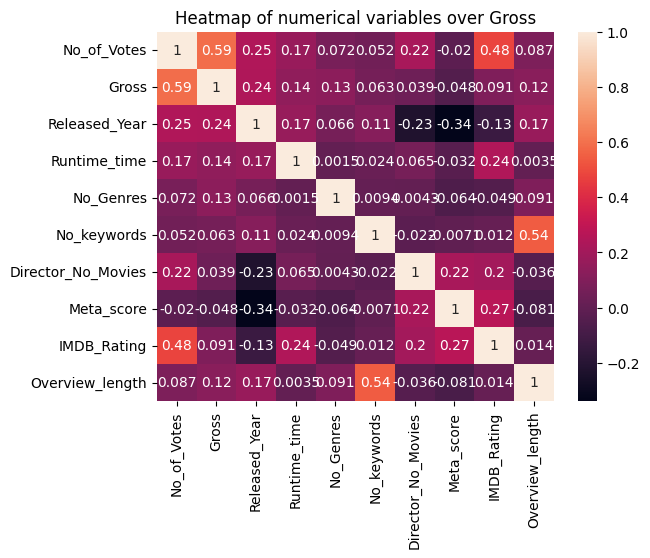

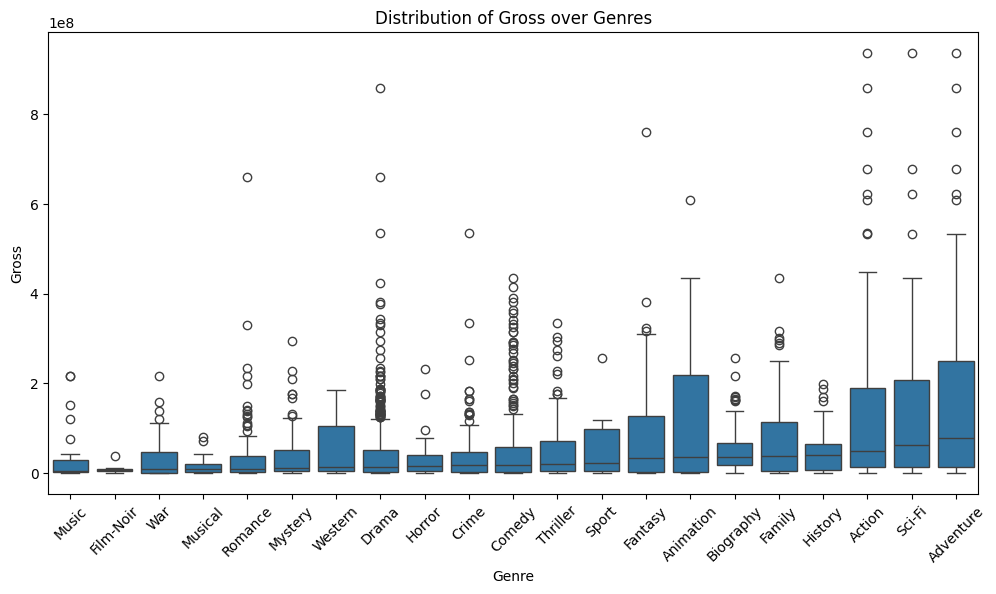

f-statistic: 18.64667027542853
p-value: 7.217949029430298e-62
Rejeitamos a hipótese nula.
O teste ANOVA dá indícios de que as médias de Gross são diferentes entre os gêneros.


In [32]:
gross_corr = dataset[['No_of_Votes','Gross', 'Released_Year', 'Runtime_time', 'No_Genres', 'No_keywords', 'Director_No_Movies', 'Meta_score', 'IMDB_Rating', 'Overview_length']].corr()

sns.heatmap(gross_corr, annot=True)
plt.title('Heatmap of numerical variables over Gross')
plt.show()

df_genre_gross = dataset.assign(Genre=dataset["Genre"].str.split(", ")).explode("Genre").reset_index()

plt.figure(figsize=(12,6))
sns.boxplot(data=df_genre_gross, x="Genre", y="Gross", order=df_genre_gross.groupby("Genre")["Gross"].median().sort_values().index)
plt.xticks(rotation=45)
plt.title('Distribution of Gross over Genres')
plt.show()

groups = [group['Gross'].values for name, group in df_genre_gross.groupby('Genre', observed=True)]

f_stat, p_val = f_oneway(*groups)
print(f'f-statistic: {f_stat}')
print(f'p-value: {p_val}')

if p_val < 0.05:
    print('Rejeitamos a hipótese nula.')
    print('O teste ANOVA dá indícios de que as médias de Gross são diferentes entre os gêneros.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('O teste ANOVA não dá indícios de que as médias de Gross sejam diferentes entre os gêneros.')

In [33]:
# Salvando o dataset tratado para utilizar em um novo notebook somente para os modelos.

dataset.to_csv('./desafio_indicium_imdb_after_process.csv', sep=';')